In [1]:
%pylab inline

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from copy import deepcopy
from collections import defaultdict
import matplotlib as plt
import pickle
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
results_buf1 = []
results_buf2 = []
results_buf3 = []

In [3]:
def get_dict_by_qid(qids, pred_y):
    """
        Возвращает словарь, в котором по qid можно получить список индексов. 
        Каждый индекс соответствует месту элемента с этим индексом в поисковой выдаче для данного qid.
    """
    # Найдём для каждого из запросов порядок поисковой выдачи
    unique_qids = np.unique(qids)
    id_y = defaultdict(np.array)
    n_elems = pred_y.shape[0]
    for qid in unique_qids:
        # Индексы тех элементов, у которых запрос равен qid
        ids_for_qid = np.arange(n_elems)[qids==qid]
        # Тот же pred_y, только, у которого элементы с неравным qid будут равны 0
        buf = np.zeros(n_elems)
        for idx in ids_for_qid:
            buf[idx] = pred_y[idx]
        id_y[qid] = np.argsort(np.argsort(buf)[::-1])
    return id_y


def ndcgl(pred_y, y, qids, L=10):
    """
        pred_y : предсказанные значения функции ранжирования
        y : метки релевантности
        qids : id запросов, для каждого элемента
    """
    id_y = get_dict_by_qid(qids, pred_y)
    buf = 0.
    for qid in np.unique(qids):
        dcgl = 0.
        idcgl = 0.
        # Отсортируем значения по убыванию функции ранжирования
        #idx = np.argsort(y_pred)[::-1]
        idx = id_y[qid]
        # Метки релевантности для отсортированного массива y_pred
        #l = y[idx]
        for i in xrange(L):
            #if qids[i] == qid:
            # Метка релевантности для данного элемента
            l = y[idx == i][0]
            dcgl += (2. ** l - 1) / np.log2(i + 2)
            idcgl += 1 / np.log2(i + 2)
        buf += dcgl / idcgl
    return buf / len(np.unique(qids))

In [26]:
class LambdaMART:
    def __init__(self, n_estimators, base_estimator=DecisionTreeRegressor(), step_estimator=DecisionTreeRegressor(),
                 alpha=1., beta=1., adaptive_step=True, feature_subset=False, feature_fraction=1., stochastic=False):
        """
            n_estimators : число деревьев в обучении
            base_estimator : выбор модели для каждой итерации
            step_estimator : выбор модели для предсказания темпа обучения
            alpha : коэффициент регуляризации XGBoost
            beta : коэффициент при предсказании темпа обучения
            adaptive_step : использовать адаптивный шаг бустинга или нет
            feature_subset : использовать случайный набор признаков или нет
        """
        self.estimators = []
        self.step_estimators = []
        self.feature_idx = []
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.step_estimator = step_estimator
        self.alpha = alpha
        self.beta = beta
        self.adaptive_step = adaptive_step
        self.feature_subset = feature_subset
        self.feature_fraction = feature_fraction
        self.stochastic = stochastic
        
    def fit(self, X_train, y_train, qids_train, queries_train, X_test, y_test, qids_test, queries_test, verbose=False):
        """
            X : признаки пар запрос-документ
            y : метки релевантности
            qids : id запросов
            queries : признаки запросов
        """
        X = X_train
        y = y_train
        qids = qids_train
        queries = queries_train
        self.estimators = []
        self.step_estimators = []
        self.last_iteration = 0
        # Препроцессинг для ускорения подсчитывания градиента
        # id_y = np.argsort(np.argsort(y_train)[::-1])
        for i in xrange(self.n_estimators):
            predicted = self.predict(X_train, qids_train, queries_train, verbose)
            y_pred = self.predict(X_test, qids_test, queries_test)
            train_result = ndcgl(predicted, y_train, qids_train)
            test_result = ndcgl(y_pred, y_test, qids_test)
            print "Iteration {}, train_result {}, test_result {}".format(i, train_result, test_result)
            if self.feature_subset:
                results_buf1.append((i, train_result, test_result))
            else:
                results_buf2.append((i, train_result, test_result))
                #print "Iteration ", i, "train_result", ndcgl(predicted) "" test_result ", 
            sub_idx = []
            if self.stochastic:
                # Выбираем подвыборку элементов
                sub_idx = np.random.choice(np.arange(X_train.shape[0]), int(0.6 * X_train.shape[0]), replace=False)
                #grad, h = self.loss_grad(predicted[sub_idx], y_train[sub_idx], id_y[sub_idx])
                grad, h = self.loss_grad(predicted[sub_idx], y_train[sub_idx], qids_train[sub_idx])
                X = X_train[sub_idx]
                y = y_train[sub_idx]
                qids = qids_train[sub_idx]
                queries = queries_train[sub_idx]
            else:
                #grad, h = self.loss_grad(predicted, y, id_y)
                grad, h = self.loss_grad(predicted, y, qids)
            if verbose:
                print "Grad:"
                print grad
                print "H:"
                print h
            estimator = deepcopy(self.base_estimator)
            if self.feature_subset:
                # Список индексов фичей
                feature_idx = np.random.choice(np.arange(X.shape[1]), int(self.feature_fraction * X.shape[1]), replace=False)
                self.feature_idx.append(feature_idx)
                estimator.fit(X.T[feature_idx].T, -grad/ (self.alpha + h))
            else:
                estimator.fit(X, -grad/ (self.alpha + h))
            self.estimators.append(estimator)
            if verbose:
                print "Predict:"
                print predicted
            # Обучим предсказатель шага
            if self.adaptive_step:
                step_estimator = deepcopy(self.step_estimator)
                # Список всех запросов(уникальных)
                qs = np.unique(qids)
                # Список значений того, что нужно предсказывать
                pred_values = np.zeros(len(qs))
                q_list = np.zeros((len(qs), queries.shape[1]))
                for idx, q in enumerate(qs):
                    # Суммируем значения по всем элементам с данным запросом q
                    pred_values[idx] = 0.
                    for j in xrange(X.shape[0]):
                        if qids[j] == q:
                            q_list[idx] = queries[j]
                            pred_values[idx] += 1. / (1. + self.beta * h[j])            
                    #q_list[idx] = q_dict[q]
                sum_pred_values = np.sum(pred_values)
                step_estimator.fit(q_list, pred_values * len(qs) / sum_pred_values)
                self.step_estimators.append(step_estimator)
            self.last_iteration = i
            if i % 50 == 0:
                # Выгрузить информацию об алгоритме в файл
                name = ""
                if self.feature_subset:
                    name = "fs_algo"
                else:
                    name = "no_fs_algo"
                if self.stochastic:
                    name = "stoch_algo"
                pickle.dump(self, open(name, "wb"))
        return self
            
    def predict(self, X, qids, queries, verbose=False):
        y_pred = np.zeros(X.shape[0])
        for est_i, estimator in enumerate(self.estimators):
            if self.feature_subset:
                feature_idx = self.feature_idx[est_i]
                est_result = estimator.predict(X.T[feature_idx].T)
            else:
                est_result = estimator.predict(X)
            for i in xrange(X.shape[0]):
                step = 1. / (i + 1.)
                if self.adaptive_step:
                    step = self.step_estimators[est_i].predict(queries[i].reshape(1,-1)[0])
                if verbose:
                    print "Step: ", step, " for qid=", qids[i]
                y_pred[i] += est_result[i] * step
        return y_pred
    
    def continue_fit(self, n_estimators, X_train, y_train, qids_train, queries_train, X_test, y_test, qids_test, queries_test):
        X = X_train
        y = y_train
        qids = qids_train
        queries = queries_train
        prev_n_estimators = self.n_estimators
        self.n_estimators = n_estimators
        # Препроцессинг для ускорения подсчитывания градиента
        # id_y = np.argsort(np.argsort(y_train)[::-1])
        for i in xrange(prev_n_estimators, self.n_estimators):
            predicted = self.predict(X_train, qids_train, queries_train, False)
            y_pred = self.predict(X_test, qids_test, queries_test)
            train_result = ndcgl(predicted, y_train, qids_train)
            test_result = ndcgl(y_pred, y_test, qids_test)
            print "Iteration {}, train_result {}, test_result {}".format(i, train_result, test_result)
            if self.feature_subset:
                results_buf1.append((i, train_result, test_result))
            else:
                results_buf2.append((i, train_result, test_result))
            sub_idx = []
            if self.stochastic:
                # Выбираем подвыборку элементов
                sub_idx = np.random.choice(np.arange(X_train.shape[0]), int(0.6 * X_train.shape[0]), replace=False)
                grad, h = self.loss_grad(predicted[sub_idx], y_train[sub_idx], qids_train[sub_idx])
                X = X_train[sub_idx]
                y = y_train[sub_idx]
                qids = qids_train[sub_idx]
                queries = queries_train[sub_idx]
            else:
                grad, h = self.loss_grad(predicted, y, qids)
            estimator = deepcopy(self.base_estimator)
            if self.feature_subset:
                # Список индексов фичей
                feature_idx = np.random.choice(np.arange(X.shape[1]), int(self.feature_fraction * X.shape[1]), replace=False)
                self.feature_idx.append(feature_idx)
                estimator.fit(X.T[feature_idx].T, -grad/ (self.alpha + h))
            else:
                estimator.fit(X, -grad/ (self.alpha + h))
            self.estimators.append(estimator)
            # Обучим предсказатель шага
            if self.adaptive_step:
                step_estimator = deepcopy(self.step_estimator)
                # Список всех запросов(уникальных)
                qs = np.unique(qids)
                # Список значений того, что нужно предсказывать
                pred_values = np.zeros(len(qs))
                q_list = np.zeros((len(qs), queries.shape[1]))
                for idx, q in enumerate(qs):
                    # Суммируем значения по всем элементам с данным запросом q
                    pred_values[idx] = 0.
                    for j in xrange(X.shape[0]):
                        if qids[j] == q:
                            q_list[idx] = queries[j]
                            pred_values[idx] += 1. / (1. + self.beta * h[j])            
                    #q_list[idx] = q_dict[q]
                sum_pred_values = np.sum(pred_values)
                step_estimator.fit(q_list, pred_values * len(qs) / sum_pred_values)
                self.step_estimators.append(step_estimator)
            self.last_iteration = i
            if i % 50 == 0:
                # Выгрузить информацию об алгоритме в файл
                name = ""
                if self.feature_subset:
                    name = "fs_algo"
                else:
                    name = "no_fs_algo"
                if self.stochastic:
                    name = "stoch_algo"
                pickle.dump(self, open(name, "wb"))
        return self
    
    def loss_grad(self, pred_y, y, qids):
        n_elems = y.shape[0]
        grad = np.zeros(n_elems)
        h = np.zeros(n_elems)
        # id_y - индексы в массиве pred_y, отсортированные по убыванию ранжирующей функции 
        #id_y = np.argsort(np.argsort(y)[::-1])
        # Найдём для каждого из запросов порядок поисковой выдачи
        id_y = get_dict_by_qid(qids, pred_y)
        for i in xrange(n_elems):
            for j in xrange(n_elems):
                if qids[i] == qids[j]:
                    buf = 0.
                    delta_ndcg = np.abs(self.ndcg_replace(y[i], y[j], id_y[qids[i]][i], id_y[qids[j]][j]))
                    if y[i] > y[j]:
                        buf = -self.rho(pred_y[i], pred_y[j])
                    if y[i] < y[j]:
                        buf = self.rho(pred_y[j], pred_y[i])
                    if buf != 0.:
                        grad[i] += delta_ndcg * buf
                    h[i] += delta_ndcg * self.rho(pred_y[i], pred_y[j]) * (1 - self.rho(pred_y[i], pred_y[j]))
        return grad, h
    
    def ndcg_replace(self, value_a, value_b, id_a, id_b):
        return (2. ** value_b - 2. ** value_a) * (1./ np.log2(2 + id_a) - 1./ np.log2(2 + id_b))
    
    def rho(self, a, b):
        return 1. / (1. + np.exp(a - b))

Считаем часть датасета MQ2007

In [5]:
# Проверка на части датасета MQ2007
fin = open('train.txt', 'r')

num_elems = 10000
X = np.zeros((num_elems, 46))
y = np.zeros(num_elems)
queries = np.zeros(num_elems)

num = 0
i = 0

lines = fin.readlines()[:num_elems]

for i, line in enumerate(lines):
    parsed = line.split(' ')
    y[i] = int(parsed[0])
    queries[i] = int(parsed[1][4:])
    for j in xrange(46):
        if j < 9:
            X[i][j] = float(parsed[j + 2][2:])
        else:
            X[i][j] = float(parsed[j + 2][3:])
                
# Нормализуем y
y /= np.max(y)

Генерируем признаки для запросов

In [6]:
from collections import defaultdict

# Признаки для запросов
query_d = 20 # Число признаков в запросе. 
q_dict = defaultdict(lambda : np.zeros(query_d)) # dictionary, который по id запроса возвращает его признаки

unique_q, counts = np.unique(queries, return_counts=True)
for i,q in enumerate(unique_q):
    for j in xrange(X.shape[0]):
        if queries[j] == q:
            q_dict[q] += X[j][11:31]/ counts[i]
            #q_dict[q] += X[j][:40]/ counts[i]

# Финальная матрица для запросов. По индексу получаем признаки запроса, соответствующие элементу из X с этим индексом
q = np.zeros((num_elems, query_d))
for i in xrange(num_elems):
    q[i] = q_dict[queries[i]]

In [7]:
# Хорошее перемешивание
unique_q = np.unique(queries)
num_q = unique_q.shape[0]
q_idx = np.random.permutation(num_q)
Q_for_train = unique_q[q_idx][:num_q*3/4]
Q_for_test = unique_q[q_idx][num_q*3/4:]

train_idx = np.zeros(0, dtype=int32)
test_idx = np.zeros(0, dtype=int32)

for i, q_id in enumerate(queries):
    if (Q_for_train == q_id).any():
        train_idx = np.append(train_idx, int(i))
    else:
        test_idx = np.append(test_idx, int(i))

X_train = X[train_idx]
y_train = y[train_idx]
q_train = queries[train_idx]
queries_train = q[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]
q_test = queries[test_idx]
queries_test = q[test_idx]

### Результаты на 10000 элементах

In [9]:
clf_temp = DecisionTreeRegressor().fit(X_train, y_train)
print ndcgl(clf_temp.predict(X_test), y_test, q_test)
print ndcgl(clf_temp.predict(X_train), y_train, q_train)

0.155186474972
0.432043887205


In [27]:
n = 301
clf2 = LambdaMART(n, alpha=0.5, beta=1., feature_subset=True, feature_fraction=0.3)
clf1 = LambdaMART(n, alpha=0.5, beta=1.)
clf3 = LambdaMART(n, alpha=0.5, beta=1., feature_subset=True, feature_fraction=0.3, stochastic=True)
results_buf1 = []
results_buf2 = []
results_buf3 = []

In [28]:
%time clf2 = clf2.fit(X_train, y_train, q_train, queries_train, X_test, y_test, q_test, queries_test)

Iteration 0, train_result 0.0, test_result 0.0
Iteration 1, train_result 0.4099556694, test_result 0.151405349521
Iteration 2, train_result 0.42131550436, test_result 0.164070825496
Iteration 3, train_result 0.421515919601, test_result 0.16653721379
Iteration 4, train_result 0.421371916359, test_result 0.171495621272
Iteration 5, train_result 0.421371916359, test_result 0.175859514664
Iteration 6, train_result 0.421521880282, test_result 0.173748044054
Iteration 7, train_result 0.421093474441, test_result 0.173461176337
Iteration 8, train_result 0.420878924571, test_result 0.175060916901
Iteration 9, train_result 0.420686206352, test_result 0.178050653385
Iteration 10, train_result 0.420830209595, test_result 0.178818616504
Iteration 11, train_result 0.420830209595, test_result 0.175598856777
Iteration 12, train_result 0.420686206352, test_result 0.177729969935
Iteration 13, train_result 0.420536242429, test_result 0.180014896336
Iteration 14, train_result 0.420536242429, test_result 0

In [29]:
clf2.continue_fit(301, X_train, y_train, q_train, queries_train, X_test, y_test, q_test, queries_test)

Iteration 300, train_result 0.424487934794, test_result 0.184438433769


<__main__.LambdaMART instance at 0x000000000863FF88>

In [11]:
%time clf1 = clf1.fit(X_train, y_train, q_train, queries_train, X_test, y_test, q_test, queries_test)

Iteration 0, train_result 0.0575187075567, test_result 0.0
Iteration 1, train_result 0.412304768093, test_result 0.145115627204
Iteration 2, train_result 0.421008818461, test_result 0.156843561133
Iteration 3, train_result 0.42136294864, test_result 0.150048394382
Iteration 4, train_result 0.421471283526, test_result 0.151543081687
Iteration 5, train_result 0.421471283526, test_result 0.160954537966
Iteration 6, train_result 0.421305227069, test_result 0.15883096458
Iteration 7, train_result 0.421305227069, test_result 0.163381553307
Iteration 8, train_result 0.421305227069, test_result 0.165640210481
Iteration 9, train_result 0.421305227069, test_result 0.170145311329
Iteration 10, train_result 0.421305227069, test_result 0.17263287084
Iteration 11, train_result 0.421305227069, test_result 0.170039048498
Iteration 12, train_result 0.421471283526, test_result 0.171257269129
Iteration 13, train_result 0.421471283526, test_result 0.172916894992
Iteration 14, train_result 0.421628438464, 

KeyboardInterrupt: 

In [22]:
%time clf3 = clf3.fit(X_train, y_train, q_train, queries_train, X_test, y_test, q_test, queries_test)

Iteration 0, train_result 0.0, test_result 0.217260712852
Iteration 1, train_result 0.326793823339, test_result 0.167990895184
Iteration 2, train_result 0.350218945077, test_result 0.168031252584
Iteration 3, train_result 0.376366642672, test_result 0.169533245177
Iteration 4, train_result 0.392124451835, test_result 0.169470632113
Iteration 5, train_result 0.40035966417, test_result 0.166862935522
Iteration 6, train_result 0.406648531108, test_result 0.168544369952
Iteration 7, train_result 0.40941328885, test_result 0.169543598297
Iteration 8, train_result 0.411843468875, test_result 0.173384550953
Iteration 9, train_result 0.412434463142, test_result 0.173335317435
Iteration 10, train_result 0.413233253238, test_result 0.175435423385
Iteration 11, train_result 0.413649908937, test_result 0.176665511579
Iteration 12, train_result 0.41357004004, test_result 0.175898041207
Iteration 13, train_result 0.413889205266, test_result 0.175593811644
Iteration 14, train_result 0.413968919486, t

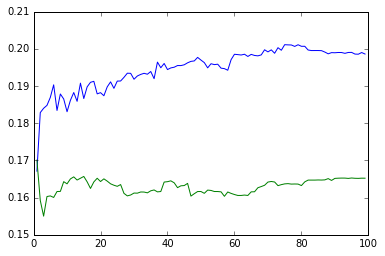

In [53]:
# Визуализация
axis_x = map(lambda x: x[0], results_buf1)[1:100]
train_y1 = map(lambda x: x[1], results_buf1)[1:100]
test_y1 = map(lambda x: x[2], results_buf1)[1:100]
train_y2 = map(lambda x: x[1], results_buf2)[1:100]
test_y2 = map(lambda x: x[2], results_buf2)[1:100]
#pylab.plot(axis_x, train_y)
pylab.plot(axis_x, test_y1)
pylab.plot(axis_x, test_y2)

In [20]:
len(results_buf1), len(results_buf2), len(results_buf3)

(301, 296, 300)

In [6]:
%matplotlib auto

Using matplotlib backend: Qt4Agg


In [22]:
# Визуализация
axis_x = map(lambda x: x[0], results_buf1)[1:295]
train_y1 = map(lambda x: x[1], results_buf1)[1:295]
test_y1 = map(lambda x: x[2], results_buf1)[1:295]
train_y2 = map(lambda x: x[1], results_buf2)[1:295]
test_y2 = map(lambda x: x[2], results_buf2)[1:295]
train_y3 = map(lambda x: x[1], results_buf3)[1:295]
test_y3 = map(lambda x: x[2], results_buf3)[1:295]
#pylab.plot(axis_x, train_y)
pylab.plot(axis_x, test_y1)
pylab.plot(axis_x, test_y2)
pylab.plot(axis_x, test_y3)
blue_patch = mpatches.Patch(color='blue', label='With feature selection')
green_patch = mpatches.Patch(color='green', label='No feature selection')
red_patch = mpatches.Patch(color='red', label='Stochastic + fs')
pylab.legend(handles=[blue_patch, green_patch, red_patch])
pylab.xticks(np.arange(0, 301, 20))
pylab.yticks(np.arange(0.14, 0.205, 0.005))
pylab.grid(True)
#pylab.plot(axis_x, test_y3)
#pylab.plot(axis_x, train_y1)
#pylab.plot(axis_x, train_y2)
#pylab.plot(axis_x, train_y3)

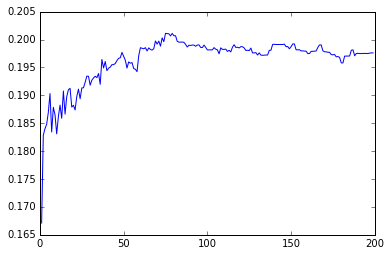

In [58]:
axis_x = map(lambda x: x[0], results_buf1)[1:]
train_y = map(lambda x: x[1], results_buf1)[1:]
test_y = map(lambda x: x[2], results_buf1)[1:]
#pylab.plot(axis_x, train_y)
pylab.plot(axis_x, test_y)

In [38]:
axis_x2 = map(lambda x: x[0], results_buf2)[1:]
train_y2 = map(lambda x: x[1], results_buf2)[1:]
test_y2 = map(lambda x: x[2], results_buf2)[1:]
pylab.plot(axis_x2, train_y2)
#pylab.plot(axis_x2, test_y2)

In [23]:
# Сохраним пока данные
with open('results_no_fs_300.txt','w+') as fout:
    for i, train, test in results_buf2:
        s = "Iteration {}, train_result {}, test_result {}\n".format(i, train, test)
        fout.write(s)

In [33]:
# Сохраним пока данные
with open('results_fs_300.txt','w+') as fout:
    for i, train, test in results_buf1:
        s = "Iteration {}, train_result {}, test_result {}\n".format(i, train, test)
        fout.write(s)

In [ ]:
# Сохраним пока данные
with open('results_stoch_300.txt','w+') as fout:
    for i, train, test in results_buf3:
        s = "Iteration {}, train_result {}, test_result {}\n".format(i, train, test)
        fout.write(s)

In [17]:
# Откроём сохранённые результаты fs
with open('results_fs_300.txt','r+') as fin:
    results_buf1 = []
    lines = fin.readlines()
    for line in lines:
        tokens = line.split(' ')
        results_buf1.append((int(tokens[1][:-1]), float(tokens[3][:-1]), float(tokens[5])))
        #print tokens[1][:-1]
        #print tokens[3][:-1]
        #print tokens[5]

In [18]:
# Откроём сохранённые результаты no_fs
with open('results_no_fs_300.txt','r+') as fin:
    results_buf2 = []
    lines = fin.readlines()
    for line in lines:
        tokens = line.split(' ')
        results_buf2.append((int(tokens[1][:-1]), float(tokens[3][:-1]), float(tokens[5])))

In [19]:
# Откроём сохранённые результаты stoch
with open('results_stoch_300.txt','r+') as fin:
    results_buf3 = []
    lines = fin.readlines()
    for line in lines:
        tokens = line.split(' ')
        results_buf3.append((int(tokens[1][:-1]), float(tokens[3][:-1]), float(tokens[5])))

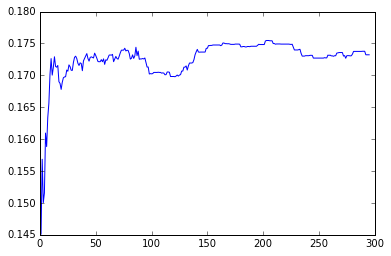

In [8]:
axis_x1 = map(lambda x: x[0], results_buf2)[1:]
train_y1 = map(lambda x: x[1], results_buf2)[1:]
test_y1 = map(lambda x: x[2], results_buf2)[1:]
#pylab.plot(axis_x, train_y)
pylab.plot(axis_x1, test_y1)

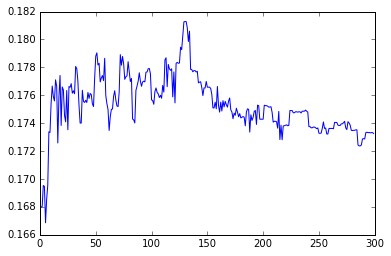

In [27]:
axis_x3 = map(lambda x: x[0], results_buf3)[1:]
train_y3 = map(lambda x: x[1], results_buf3)[1:]
test_y3 = map(lambda x: x[2], results_buf3)[1:]
#pylab.plot(axis_x, train_y)
pylab.plot(axis_x3, test_y3)

In [26]:
%matplotlib auto

Using matplotlib backend: Qt4Agg


In [42]:
import matplotlib.patches as mpatches

# Визуализация
axis_x = map(lambda x: x[0], results_buf1)[:200]
train_y1 = map(lambda x: x[1], results_buf1)[:200]
test_y1 = map(lambda x: x[2], results_buf1)[:200]
train_y2 = map(lambda x: x[1], results_buf2)[1:200]
test_y2 = map(lambda x: x[2], results_buf2)[1:200]
#pylab.plot(axis_x, train_y)
pylab.plot(axis_x, test_y1)
pylab.plot(axis_x, test_y2)
blue_patch = mpatches.Patch(color='blue', label='With feature selection')
green_patch = mpatches.Patch(color='green', label='No feature selection')
pylab.legend(handles=[blue_patch, green_patch])
pylab.xticks(np.arange(0, 201, 20))
pylab.yticks(np.arange(0.14, 0.21, 0.005))
pylab.grid(True)

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text xticklabel objects>)

### Результаты на 5000 элементах

In [8]:
n = 200
clf2 = LambdaMART(n, alpha=0.5, beta=1., feature_subset=True, feature_fraction=0.3)
clf1 = LambdaMART(n, alpha=0.5, beta=1.)

In [9]:
%time clf2 = clf2.fit(X_full_train, y_full_train, q_full_train, queries_full_train, X_test, y_test, q_test, queries_test)

Iteration  1  result  0.0287593537783
Iteration  31  result  0.852402040229
Iteration  61  result  0.918656263683
Iteration  91  result  0.935536614135
Iteration  121  result  0.935536614135
Iteration  151  result  0.935536614135
Iteration  181  result  0.935536614135
Wall time: 5h 40min 27s


In [10]:
%time clf1 = clf1.fit(X_full_train, y_full_train, q_full_train, queries_full_train, X_test, y_test, q_test, queries_test)

Iteration  1  result  0.24469999225
Iteration  31  result  0.803626307519
Iteration  61  result  0.802526356657
Iteration  91  result  0.802526356657
Iteration  121  result  0.805159791912
Iteration  151  result  0.868780580111
Iteration  181  result  0.805159791912


KeyboardInterrupt: 

In [31]:
# Небольшой GridSearch с кросс-валидацией
from numpy import unravel_index

import warnings
warnings.filterwarnings('ignore')

arr_a = [0.5, 1., 2.] # Одно значение в целях оптимизации
arr_L = [1, 2, 5, 7]
arr_b = [0.5, 1., 2.] # Одно значение в целях оптимизации

results1 = np.zeros((len(arr_a), len(arr_L), len(arr_b))) # С адаптивным шагом
results2 = np.zeros((len(arr_a), len(arr_L), len(arr_b))) # Без адаптивного шага

for i_a, a in enumerate(arr_a):
    for i_L, L in enumerate(arr_L):
        for i_b, b in enumerate(arr_b):
            for k in xrange(5):
                # Перемешаем
                shuffle_idx = np.random.permutation(num_elems)
                X_train = X[shuffle_idx][:num_elems/2.]
                X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]

                y_train = y[shuffle_idx][:num_elems/2.]
                y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]

                q_train = queries[shuffle_idx][:num_elems/2.]
                q_valid = queries[shuffle_idx][num_elems/2.:num_elems*3./4.]

                queries_train = q[shuffle_idx][:num_elems/2.]
                queries_valid = q[shuffle_idx][num_elems/2.:num_elems*3./4.]
                
                clf1 = LambdaMART(L, alpha=a, beta=b).fit(X_train, y_train, q_train, queries_train)
                y_pred1 = clf1.predict(X_valid, q_valid, queries_valid)
                results1[i_a, i_L, i_b] += ndcgl(y_pred1, y_valid) / 5.

                clf2 = LambdaMART(L, alpha=a, beta=b, adaptive_step=False).fit(X_train, y_train, q_train, queries_train)
                y_pred2 = clf2.predict(X_valid, q_valid, queries_valid)
                results2[i_a, i_L, i_b] += ndcgl(y_pred2, y_valid) / 5.

                # Значения параметров и результаты с адаптивным шагом и без
            print a, L, b, results1[i_a, i_L, i_b], results2[i_a, i_L, i_b]

0.5 1 0.5 0.336099646865 0.334095124305
0.5 1 1.0 0.284810928463 0.336022586491
0.5 1 2.0 0.278983133131 0.235084867792
0.5 2 0.5 0.41276830698 0.325806649599
0.5 2 1.0 0.269452898252 0.219380711384
0.5 2 2.0 0.357579678573 0.328906145272
0.5 5 0.5 0.360515329939 0.291737452324
0.5 5 1.0 0.396132881545 0.352325317071
0.5 5 2.0 0.357491363348 0.307072058994
0.5 7 0.5 0.307196757893 0.243569464569
0.5 7 1.0 0.468726043507 0.381784322914
0.5 7 2.0 0.433379695178 0.35421116786
1.0 1 0.5 0.298903738381 0.329808291355
1.0 1 1.0 0.452061919927 0.348656410939
1.0 1 2.0 0.43510791712 0.279133197285
1.0 2 0.5 0.298245437817 0.270975813759
1.0 2 1.0 0.426176753028 0.298526360796
1.0 2 2.0 0.30197343755 0.296332263381
1.0 5 0.5 0.444450124696 0.334779000506
1.0 5 1.0 0.431277962121 0.373842327464
1.0 5 2.0 0.429456655432 0.344643182745
1.0 7 0.5 0.438494402494 0.358339454444
1.0 7 1.0 0.431007588023 0.367884660402
1.0 7 2.0 0.446516329361 0.336559264488
2.0 1 0.5 0.259869836501 0.210006019129
2.0 

In [32]:
ad_max = unravel_index(np.argmax(results1), results1.shape)
non_ad_max = unravel_index(np.argmax(results2), results2.shape)
        
print "Max with adaptive step - Alpha={}, L={}, beta={}".format(arr_a[ad_max[0]], arr_L[ad_max[1]], arr_b[ad_max[2]])
print "Max without adaptive step - Alpha={}, L={}, beta={}".format(arr_a[non_ad_max[0]], arr_L[non_ad_max[1]], arr_b[non_ad_max[2]])

print "Maximum with adaptive step=", np.max(results1)
print "Maximum without adaptive step=", np.max(results2)

Max with adaptive step - Alpha=0.5, L=7, beta=1.0
Max without adaptive step - Alpha=2.0, L=7, beta=2.0
Maximum with adaptive step= 0.468726043507
Maximum without adaptive step= 0.394820552599


В принципе, из списка на всех параметрах видны корреляции для адаптивного и неадаптивного методов. И как правило, увеличение числа итераций хорошо влияет на результат. Можно было продолжить и далее, но в виду ограниченных мощностей, пока это не главное.

In [44]:
result1 = 0.
result2 = 0.

for k in xrange(5):
    shuffle_idx = np.random.permutation(num_elems)
    X_train = X[shuffle_idx][:num_elems/2.]
    X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]
    X_test = X[shuffle_idx][num_elems*3./4.:]

    y_train = y[shuffle_idx][:num_elems/2.]
    y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]
    y_test = y[shuffle_idx][num_elems*3./4.:]

    q_train = queries[shuffle_idx][:num_elems/2.]
    q_valid = queries[shuffle_idx][num_elems/2.:num_elems*3./4.]
    q_test = queries[shuffle_idx][num_elems*3./4.:]

    queries_train = q[shuffle_idx][:num_elems/2.]
    queries_valid = q[shuffle_idx][num_elems/2.:num_elems*3./4.]
    queries_test = q[shuffle_idx][num_elems*3./4.:]
    
    X_full_train = np.append(X_train, X_valid, axis=0)
    y_full_train = np.append(y_train, y_valid)
    q_full_train = np.append(q_train, q_valid)
    queries_full_train = np.append(queries_train, queries_valid, axis=0)
    
    clf1 = LambdaMART(7, alpha=0.5, beta=1.).fit(X_full_train, y_full_train, q_full_train, queries_full_train)
    y_pred1 = clf1.predict(X_test, q_test, queries_test)

    clf2 = LambdaMART(7, alpha=2.0, beta=2.0, adaptive_step=False).fit(X_full_train, y_full_train, q_full_train, queries_full_train)
    y_pred2 = clf2.predict(X_test, q_test, queries_test)
    
    result1 += ndcgl(y_pred1, y_test) / 5.
    result2 += ndcgl(y_pred2, y_test) / 5.

print "Adaptive=", result1
print "Non-adaptive=", result2

Adaptive= 0.473884366146
Non-adaptive= 0.328375116338


In [34]:
# Обычный DecisionTreeRegressor
tempresult = 0.

for k in xrange(5):
    shuffle_idx = np.random.permutation(num_elems)
    X_train = X[shuffle_idx][:num_elems/2.]
    X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]
    X_test = X[shuffle_idx][num_elems*3./4.:]

    y_train = y[shuffle_idx][:num_elems/2.]
    y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]
    y_test = y[shuffle_idx][num_elems*3./4.:]
    
    X_full_train = np.append(X_train, X_valid, axis=0)
    y_full_train = np.append(y_train, y_valid)

    tempclf = DecisionTreeRegressor().fit(X_full_train, y_full_train)
    tempresult += ndcgl(tempclf.predict(X_test), y_test) / 5.
    
print tempresult

0.349995209906


In [43]:
# GDBT
from sklearn.ensemble import GradientBoostingRegressor

tempresult = 0.

for k in xrange(5):
    shuffle_idx = np.random.permutation(num_elems)
    X_train = X[shuffle_idx][:num_elems/2.]
    X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]
    X_test = X[shuffle_idx][num_elems*3./4.:]

    y_train = y[shuffle_idx][:num_elems/2.]
    y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]
    y_test = y[shuffle_idx][num_elems*3./4.:]
    
    X_full_train = np.append(X_train, X_valid, axis=0)
    y_full_train = np.append(y_train, y_valid)

    tempclf = GradientBoostingRegressor().fit(X_full_train, y_full_train)
    tempresult += ndcgl(tempclf.predict(X_test), y_test) / 5.
    
print tempresult

0.424421739725


### LambdaMART из XGBoost

In [30]:
# Необходимые технические строки. Исполняйте их в случае ошибки WindowsError Error 127. 
# Путь заменить на своё расположение mingw-64
dir = r'C:\Program Files\mingw-w64\x86_64-6.2.0-posix-seh-rt_v5-rev1\mingw64\bin'
import os

os.environ['PATH'].find(dir)
os.environ['PATH'] = dir + ';' + os.environ['PATH']

In [31]:
import xgboost as xgb

In [32]:
clf_temp = xgb.XGBClassifier(objective='rank:ndcg')
clf_temp.fit(X_train, y_train)
print ndcgl(clf_temp.predict(X_test), y_test, q_test)
print ndcgl(clf_temp.predict(X_train), y_train, q_train)

0.147214344763
0.410943681227


In [40]:
tempresult = 0.

for k in xrange(5):
    shuffle_idx = np.random.permutation(num_elems)
    X_train = X[shuffle_idx][:num_elems/2.]
    X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]
    X_test = X[shuffle_idx][num_elems*3./4.:]

    y_train = y[shuffle_idx][:num_elems/2.]
    y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]
    y_test = y[shuffle_idx][num_elems*3./4.:]
    
    X_full_train = np.append(X_train, X_valid, axis=0)
    y_full_train = np.append(y_train, y_valid)
    
    clf = xgb.XGBClassifier(objective='rank:ndcg')
    clf.fit(X_full_train,y_full_train)
    tempresult += ndcgl(clf.predict(X_test), y_test) / 5.
    
print tempresult

0.434840804088


### Работа на 4000 элементах, 70 итераций бустинга

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
shuffle_idx = np.random.permutation(num_elems)
X_train = X[shuffle_idx][:num_elems/2.]
X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]
X_test = X[shuffle_idx][num_elems*3./4.:]

y_train = y[shuffle_idx][:num_elems/2.]
y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]
y_test = y[shuffle_idx][num_elems*3./4.:]

q_train = queries[shuffle_idx][:num_elems/2.]
q_valid = queries[shuffle_idx][num_elems/2.:num_elems*3./4.]
q_test = queries[shuffle_idx][num_elems*3./4.:]

queries_train = q[shuffle_idx][:num_elems/2.]
queries_valid = q[shuffle_idx][num_elems/2.:num_elems*3./4.]
queries_test = q[shuffle_idx][num_elems*3./4.:]

X_full_train = np.append(X_train, X_valid, axis=0)
y_full_train = np.append(y_train, y_valid)
q_full_train = np.append(q_train, q_valid)
queries_full_train = np.append(queries_train, queries_valid, axis=0)

%time clf_big = LambdaMART(70, alpha=0.5, beta=1., ).fit(X_full_train, y_full_train, q_full_train, queries_full_train)
#y_pred1 = clf1.predict(X_test, q_test, queries_test)

Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
Iteration # 57
Iteration # 58
Iteration # 59
Iteration # 60
Iteration # 61
Iteration # 62
Iteration # 63
Iteration # 64
Iteration # 65
Iteration # 66
Itera

In [12]:
y_pred_big = clf_big.predict(X_test, q_test, queries_test)
print ndcgl(y_pred_big, y_test)

0.896477581668


In [16]:
# xgboost
clf = xgb.XGBClassifier(objective='rank:ndcg')
clf.fit(X_full_train,y_full_train)
print ndcgl(clf.predict(X_test), y_test)

0.733113475428


### Проверка случайного выбора фичей

In [7]:
shuffle_idx = np.random.permutation(num_elems)
X_train = X[shuffle_idx][:num_elems/2.]
X_valid = X[shuffle_idx][num_elems/2.:num_elems*3./4.]
X_test = X[shuffle_idx][num_elems*3./4.:]

y_train = y[shuffle_idx][:num_elems/2.]
y_valid = y[shuffle_idx][num_elems/2.:num_elems*3./4.]
y_test = y[shuffle_idx][num_elems*3./4.:]

q_train = queries[shuffle_idx][:num_elems/2.]
q_valid = queries[shuffle_idx][num_elems/2.:num_elems*3./4.]
q_test = queries[shuffle_idx][num_elems*3./4.:]

queries_train = q[shuffle_idx][:num_elems/2.]
queries_valid = q[shuffle_idx][num_elems/2.:num_elems*3./4.]
queries_test = q[shuffle_idx][num_elems*3./4.:]

X_full_train = np.append(X_train, X_valid, axis=0)
y_full_train = np.append(y_train, y_valid)
q_full_train = np.append(q_train, q_valid)
queries_full_train = np.append(queries_train, queries_valid, axis=0)

results = []

for n in xrange(10, 600, 30):
    print n

    clf1 = LambdaMART(n, alpha=0.5, beta=1.).fit(X_full_train, y_full_train, q_full_train, queries_full_train)
    clf2 = LambdaMART(n, alpha=0.5, beta=1., feature_subset=True, feature_fraction=0.3).fit(X_full_train, y_full_train, q_full_train, queries_full_train)
    clf3 = LambdaMART(n, alpha=0.5, beta=1., feature_subset=True, feature_fraction=0.3, \
                      stochastic=True).fit(X_full_train, y_full_train, q_full_train, queries_full_train)
    
    result1 = ndcgl(clf1.predict(X_test, q_test, queries_test), y_test)
    result2 = ndcgl(clf2.predict(X_test, q_test, queries_test), y_test)
    result3 = ndcgl(clf3.predict(X_test, q_test, queries_test), y_test)
    results.append((result1, result2, result3))
    
    print "Without subset", result1
    print "With subset", result2
    print "Stochastic", result3

10
Without subset 0.589559508361
With subset 0.525202845018
Stochastic 0.465555208682
40
Without subset 0.670012899467
With subset 0.851643743565
Stochastic 0.79434887815
70
Without subset 0.595825485951
With subset 0.837945450273
Stochastic 0.732566107838
100
Without subset 0.625597894605
With subset 0.805930029937
Stochastic 0.621950881675
130
Without subset 0.635118472228
With subset 0.838777861945
Stochastic 0.646343802709
160


KeyboardInterrupt: 

In [14]:
print ndcgl(clf1.predict(X_test, q_test, queries_test), y_test)
print ndcgl(clf2.predict(X_test, q_test, queries_test), y_test)

0.619296498687
0.446995121205


In [9]:
results

[(0.58955950836136284, 0.52520284501832992, 0.46555520868212591),
 (0.67001289946652387, 0.85164374356483075, 0.79434887815035293),
 (0.59582548595062079, 0.83794545027274325, 0.73256610783800979),
 (0.62559789460458759, 0.80593002993736984, 0.6219508816753645),
 (0.63511847222811579, 0.83877786194521575, 0.64634380270875258)]